<a href="https://colab.research.google.com/github/hoyathali/ML_SleepEfficiency/blob/main/DeepFakeCat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS224 - Spring 2024 - HW2 - Deepfake Cat Detector
Submit **PDF** of completed IPython notebook on Canvas

**Due**: February 22, 2024 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: Hoyath Ali
  </br>
  <b>Student ID Number</b>:  862465195
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

# Overview
In this assignment you will implement some classifiers to predict whether or not images of cats are "deepfakes", i.e., generated by AI. (I used SD 1.5, and down-sampled to match CIFAR-10, which we use for real images.)

For this assignment we will use the functionality of PyTorch, HuggingFace "transformers" library for getting pretrained models, scikit-learn (for cross validation utility and for baseline logistic regression), matplotlib for visualization. Before you start, make sure you have installed all those packages in your local Jupyter instance. Or use Google Colab (which has everything you need pre-installed).

Read **all** cells carefully and answer **all** parts (both text and missing code). You will complete all the parts marked `TODO` and print desired results. (In some cases, this just means getting the code to work so the TODO section prints the correct result.)

In [1]:
import torch
# The following functions were discussed in week 4 demo
import torch.nn as nn  # neural net layers and activations
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, TensorDataset  # Super useful data utilities!
import torch.nn.init as init

# We discussed all these in week 3 demo:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



# Used for visualization
import torchvision.utils as vutils
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Turn off some annoying convergence warnings from sklearn
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## **Obtain and inspect data [3 points]**
You can download the data file here:
 https://elearn.ucr.edu/courses/125165/files/12619307/download?download_frd=1
You'll have to make them available locally or upload them to your colab instance.

Data shapes before flattening:
X: torch.Size([2000, 3, 32, 32])
y: torch.Size([2000])
X shape after flattening: torch.Size([2000, 3072])



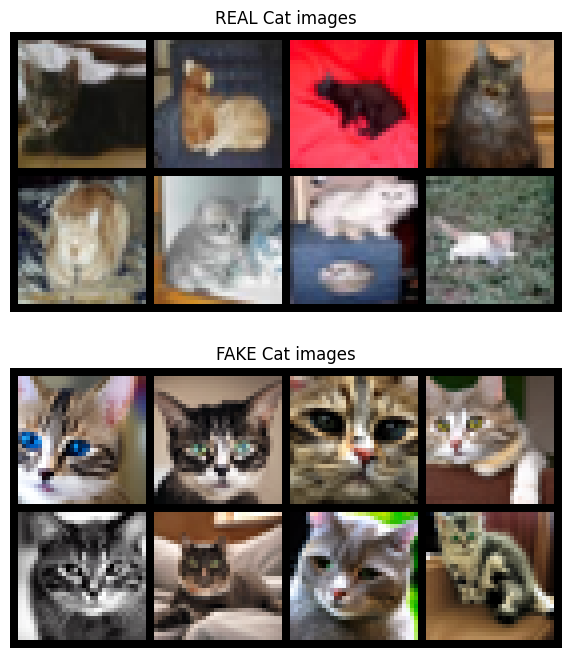

In [2]:
# Load dataset and visualize
X, y = torch.load('hw2_data.pt')

print('Data shapes before flattening:')
print('X:', X.shape)  # 2000, 3, 32, 32, 2000 images, channel, height width
print('y:', y.shape)  # 2000 binary labels 0 is real, 1 is fake

# Print examples from each class
grid = vutils.make_grid(X[y==0][:8], nrow=4, padding=2, normalize=True)
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].axis('off')
axs[0].set_title('REAL Cat images')
axs[0].imshow(grid.numpy().transpose((1, 2, 0)))

grid = vutils.make_grid(X[y==1][:8], nrow=4, padding=2, normalize=True)
axs[1].axis('off')
axs[1].set_title('FAKE Cat images')
axs[1].imshow(grid.numpy().transpose((1, 2, 0)))


X = X.flatten(start_dim=1)  # From now on, we work with the flattened vector
print(f"X shape after flattening: {X.shape}\n")

In [3]:
# TODO [3 points]:
# Use scikit-learn logistic regression (with default hyper-parameters)
# with 5-fold CV to get the train and validation accuracies
# for a simple linear classifier - a good baseline for our MLP
n_folds = 5
val_accs = []  # store validation accuracy for each fold
train_accs = []  # store training accuracy for each fold
kf = KFold(n_splits=n_folds, shuffle=True)

# TODO: iterate over folds, remember to use "shuffle=True", as datapoints are not shuffled
for trainid, valid in kf.split(X):
    X_train= X[trainid]
    X_val = X[valid]
    y_train=y[trainid]
    y_val = y[valid]
    # TODO: Fit model on training data
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    # TODO: Compute and store accuracy on train data
    predictions = model.predict(X_train)
    accuracy = accuracy_score(y_train, predictions)
    train_accs.append(accuracy)

    # TODO: Compute and store accuracy on validation data
    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    val_accs.append(accuracy)

train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
val_std, val_mean = torch.std_mean(torch.tensor(val_accs))

# Standard error is standard deviation / sqrt(n), it is more typical to report this
rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
print(f'Train Accuracy and standard error:\t {train_mean:.3f} +/- {train_std / rootn:.3f}')
print(f'Validation Accuracy and standard error:\t {val_mean:.3f} +/- {val_std / rootn:.3f}')

Train Accuracy and standard error:	 0.992 +/- 0.001
Validation Accuracy and standard error:	 0.643 +/- 0.009


## Define the model [3 points]

- As always, implement an __init__ function and a forward function
- Use Linear layers with ReLU activations for the hidden layers
- 2 layers of hidden units. First layer has 128 hidden units, second layer has 64 hidden units.
- Output represents *binary* logits (must have correct shape to do that!)

In [4]:
class MyMLP(nn.Module):
    # TODO: Define a multilayer perceptron [3 points]. Criteria above
    def __init__(self,inputsize,outputsize):
        super(MyMLP, self).__init__()
        self.fc1 = nn.Linear(inputsize, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, outputsize)
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3]:
            init.xavier_uniform_(layer.weight)
            init.zeros_(layer.bias)

    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        y = self.fc3(h2)
        return y

## Train function [6 points]
Make a function to train your neural net, following week 4 example

In [5]:
# TODO [3 points]: a function to train your model
# (this will called for each hyper-parameter and fold)
# Don't forget to set model.train() during training, then model.eval() after done
# It doesn't matter in this case, but is good practice to prevent future bugs.

def train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False):
    """Train model using data from train_loader over n_epochs,
    using a Pytorch "optimizer" object (SGD in this case)
    and "criterion" as the loss function (CrossEntropyLoss in this case).
    """
    for epoch in range(n_epochs):
        # TODO: Train loop
        model.train()
        train_loss = 0.0
        for traindata, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(traindata)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        model.eval()
        # Validation loop

        val_loss = 0.0
        with torch.no_grad():
            for traindata, labels in val_loader:
                predictions = model(traindata)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
        if verbose:
            # Optional: Validation loop
            # Print out train/val loss during development
            # User verbose=False to turn off output of this in the submitted PDF
            print(f"Epoch {epoch} , Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")
    model.eval()


Loop over hyper-parameters and do 5-fold cross-validation for each setting, saving the train and validation mean accuracy and standard error.

In [6]:
# TODO [3 points]: Perform cross-validation to get train/val accuracy
# for all hyper-parameter settings in the list below.
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0., 0.01]
batch_size = 1000
n_epochs = 100
n_folds = 5

results = []

dataset = TensorDataset(X, y)

for lr in learning_rates:
    for wd in weight_decays:
        val_accs = []  # store validation accuracy for each fold
        train_accs = []  # store training accuracy for each fold
        # TODO: iterate over folds, remember to use "shuffle=True", as datapoints are not shuffled
        kf = KFold(n_splits=n_folds, shuffle=True)
        for trainid, valid in kf.split(X):
            # TODO: Split data into train and validation
            X_train = X[trainid]
            X_val = X[valid]

            y_train = y[trainid]
            y_val= y[valid]

            # TODO: Create data loaders to pass to training loop

            train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

            # TODO: Initialize model, criterion (Cross entropy loss), and optimizer (SGD with various hyperparameters)
            model = MyMLP(32*32*3,2)
            criterion = nn.CrossEntropyLoss()
            optimizer = SGD(model.parameters(), lr=lr, weight_decay=wd)

            # Call your training function
            train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False)

            with torch.no_grad():
                # TODO: Use the trained model to estimate train/val accuracy
                # (Hint: our model outputs logits, argmax is good to get the class prediction corresponding to max logit)
                predictions = torch.argmax(model(X_train),dim=1)
                #print((train_pred == y_train).sum().item())
                train_acc = (predictions == y_train).sum().item() / len(y_train)
                train_accs.append(train_acc)

                predictions = torch.argmax(model(X_val),dim=1)
                val_acc = (predictions == y_val).sum().item() / len(y_val)
                val_accs.append(val_acc)

        # For each hyper-parameter, I'm storing the parameter values and the mean and standard error of accuracy in a list in "results".
        train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
        val_std, val_mean = torch.std_mean(torch.tensor(val_accs))
        rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
        train_se, val_se = train_std / rootn, val_std / rootn
        # Storing learning rate, weight decay value, train mean accuracy, standard error, val mean accuracy, standard error
        results.append((lr, wd, train_mean.item(), train_se.item(), val_mean.item(), val_se.item()))


print("Final Results for comparision:")
for lr, wd, train_mean, train_se, val_mean, val_se in results:
    print(f"Learning Rate: {lr}, Weight Decay: {wd}, Train Accuracy: {train_mean:.4f} +/- {train_se:.4f}, Val Accuracy: {val_mean:.4f} +/- {val_se:.4f}")

Final Results for comparision:
Learning Rate: 0.001, Weight Decay: 0.0, Train Accuracy: 0.7003 +/- 0.0049, Val Accuracy: 0.6910 +/- 0.0096
Learning Rate: 0.001, Weight Decay: 0.01, Train Accuracy: 0.7125 +/- 0.0118, Val Accuracy: 0.6805 +/- 0.0115
Learning Rate: 0.01, Weight Decay: 0.0, Train Accuracy: 0.8901 +/- 0.0045, Val Accuracy: 0.7915 +/- 0.0118
Learning Rate: 0.01, Weight Decay: 0.01, Train Accuracy: 0.8915 +/- 0.0032, Val Accuracy: 0.7975 +/- 0.0208
Learning Rate: 0.1, Weight Decay: 0.0, Train Accuracy: 0.9990 +/- 0.0004, Val Accuracy: 0.8385 +/- 0.0092
Learning Rate: 0.1, Weight Decay: 0.01, Train Accuracy: 0.9973 +/- 0.0005, Val Accuracy: 0.8115 +/- 0.0073


## Show result [3 points]

In [7]:
# TODO [3 points]. Print the final result (should be no need to modify code)
# You should be able to see a best train acc > 95% , and a best val acc > 80%

# Create a DataFrame from the list of tuples, with labeled columns
column_names = ['learning_rate', 'weight_decay', 'train_mean', 'train_se','val_mean', 'val_se']
df = pd.DataFrame(results, columns=column_names)

# Make pretty printable strings, with standard error bars
df['train_output'] = df.apply(lambda row: f"{row['train_mean']:.3f} +/- {row['train_se']:.3f}", axis=1)
df['val_output'] = df.apply(lambda row: f"{row['val_mean']:.3f} +/- {row['val_se']:.3f}", axis=1)

print('Training results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='train_output')
display(pivot_df)

print('Validation results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='val_output')
display(pivot_df)

Training results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.700 +/- 0.005,0.890 +/- 0.005,0.999 +/- 0.000
0.01,0.712 +/- 0.012,0.891 +/- 0.003,0.997 +/- 0.000


Validation results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.691 +/- 0.010,0.791 +/- 0.012,0.839 +/- 0.009
0.01,0.680 +/- 0.011,0.798 +/- 0.021,0.812 +/- 0.007


## Extra credit

There are some nice opportunities for extra credit, though I will be fairly stingy with the points, so you should only try it if you're interested in learning more.
Some examples of things you could try for 1 extra point.
- Use t-SNE or UMAP to visualize a 2-d embedding of all the points, and see if the real and fake images are separable in the 2-d space.
- Use a more complex vision backbone like a pretrained ResNet to first embed the images, then train your MLP. You'll have to be careful to transform the images before input into a ResNet, as they usually expect a specific resolution. You can use torchvision transforms library for this. Does this increase accuracy? I don't know, but I speculate it won't help much - these embeddings are trained for classification accuracy, so they have no reason to preserve differences that are useful for finding fakes.
- Train a more complex vision backbone, instead of using the MLP. Again, a ResNet or a small vision transformer would be interesting. I think this would be the most typical and effective approach.
- Being an expert at hyper-parameter tuning is a skill that will benefit you greatly. Try a more fancy way to do this, like https://docs.wandb.ai, and see how well you can do on this assigment if you also vary other hyper-parameters (architecture, n_epochs, maybe early stopping, more learning rate/weight decay settings, regularizers, etc.)

Of course you can train your deepfake detector on my fakes, but how well will it do on ones from some other system? This is the fundamental research question in that field - how to build robust detectors that will work well even on new image generators.

#Extra Credit
- using t-SNE and UMAP for 2d embeddings

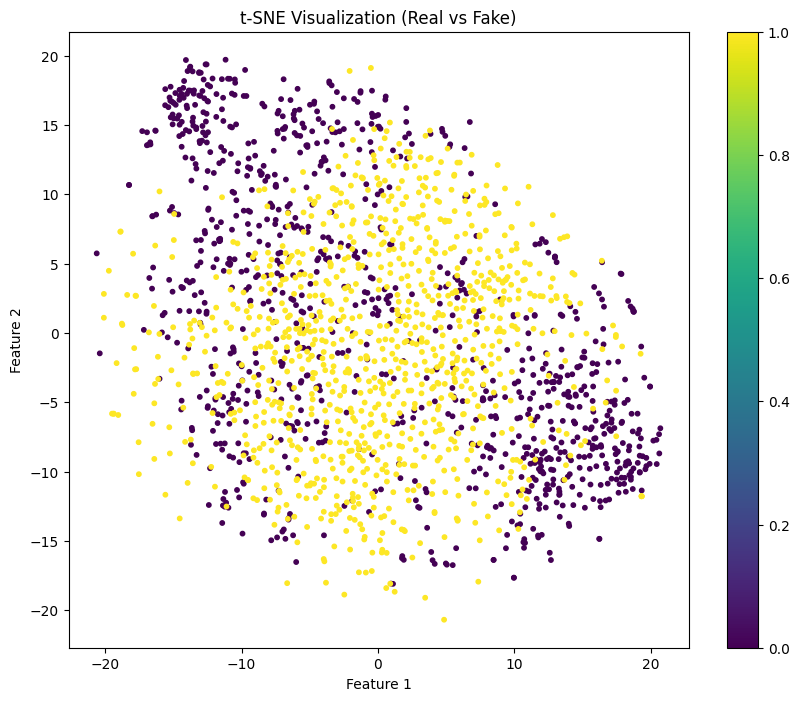

In [8]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
X_embedded_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_embedded_tsne[:, 0], X_embedded_tsne[:, 1], c=y, cmap='viridis', s=10)
plt.colorbar()
plt.title('t-SNE Visualization (Real vs Fake)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [9]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=b8ef682faaba6d58f52eb969d90c81c6c45821a26917e282c1a49002be1e7cd2
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


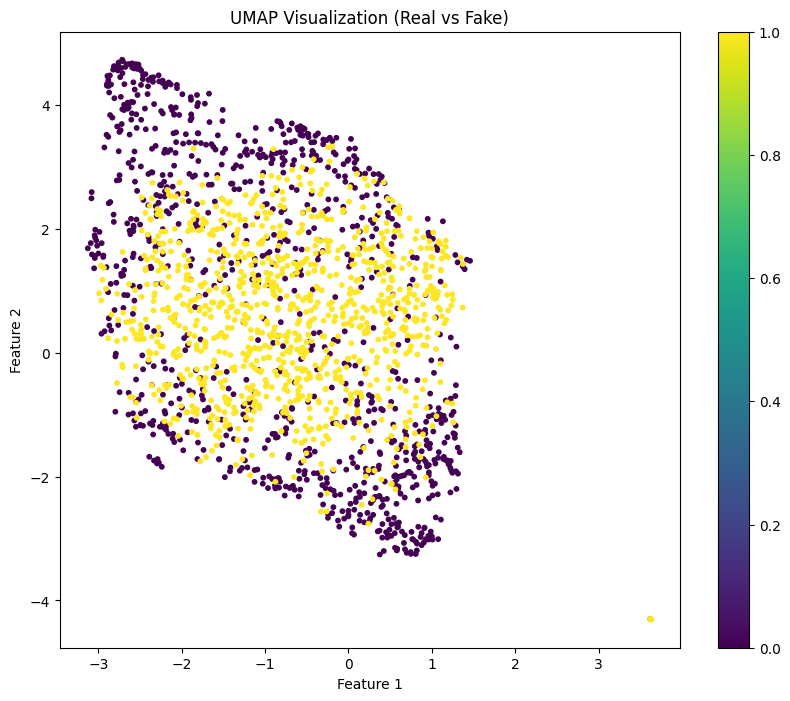

In [10]:
import umap
reducer = umap.UMAP()
X_embedded_umap = reducer.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_embedded_umap[:, 0], X_embedded_umap[:, 1], c=y, cmap='viridis', s=10)
plt.colorbar()
plt.title('UMAP Visualization (Real vs Fake)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


#Extra Points (Hyper-Parameter Tuning)
- Dropouts
- Batch Sizes
- Early stopping
- Epochs

In [11]:
class MyMLP(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate):
        super(MyMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.init_weights()

    def init_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3]:
            init.xavier_uniform_(layer.weight)
            init.zeros_(layer.bias)

    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h1 = self.dropout(h1)
        h2 = self.relu(self.fc2(h1))
        h2 = self.dropout(h2)
        y = self.fc3(h2)
        return y

In [12]:


def train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False):
    """Train model using data from train_loader over n_epochs,
    using a Pytorch "optimizer" object (SGD in this case)
    and "criterion" as the loss function (CrossEntropyLoss in this case).
    """
    best_val_loss = float('inf')
    counter = 0
    early_stopping_patience = 5
    print(f"Current Hyper Parameters Learning Rate: {lr}, Weight Decay: {wd}, Batch Size: {batch_size}")

    for epoch in range(n_epochs):
        # TODO: Train loop
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        if verbose:
            # Optional: Validation loop
            # Print out train/val loss during development
            # User verbose=False to turn off output of this in the submitted PDF
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

        if val_loss/len(val_loader) < best_val_loss:
            best_val_loss = val_loss/len(val_loader)
            counter = 0
        else:
            counter += 1
            print(f'Validation loss did not improve. Patience left: {early_stopping_patience - counter}/{early_stopping_patience}')
            if counter >= early_stopping_patience:
                print(f'Early stopping after {epoch + 1 - early_stopping_patience} epochs without improvement.')
                break

    model.eval()


In [ ]:
# TODO [3 points]: Perform cross-validation to get train/val accuracy
# for all hyper-parameter settings in the list below.
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0., 0.01, 0.05]
batch_sizes = [30,50]
dropout_rates = [0.2,0.3]
n_epochs = 200
n_folds = 5

results = []

dataset = TensorDataset(X, y)

for lr in learning_rates:
    for wd in weight_decays:
      for batch_size in batch_sizes:
        for dropout_rate in dropout_rates:
          val_accs = []  # store validation accuracy for each fold
          train_accs = []  # store training accuracy for each fold
          # TODO: iterate over folds, remember to use "shuffle=True", as datapoints are not shuffled
          kf = KFold(n_splits=n_folds, shuffle=True)
          for train_index, val_index in kf.split(X):
              X_train, X_val = X[train_index], X[val_index]
              y_train, y_val = y[train_index], y[val_index]
              # TODO: Split data into train and validation

              # TODO: Create data loaders to pass to training loop
              train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
              val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

              # TODO: Initialize model, criterion (Cross entropy loss), and optimizer (SGD with various hyperparameters)
              model = MyMLP(3072,2,dropout_rate)
              criterion = nn.CrossEntropyLoss()
              optimizer = SGD(model.parameters(), lr=lr, weight_decay=wd)

              # Call your training function
              train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False)

              with torch.no_grad():
                  # TODO: Use the trained model to estimate train/val accuracy
                  # (Hint: our model outputs logits, argmax is good to get the class prediction corresponding to max logit)
                  train_pred = torch.argmax(model(X_train),dim=1)
                  #print((train_pred == y_train).sum().item())
                  train_acc = (train_pred == y_train).sum().item() / len(y_train)
                  train_accs.append(train_acc)

                  val_pred = torch.argmax(model(X_val),dim=1)  # Convert logits to binary predictions using argmax
                  val_acc = (val_pred == y_val).sum().item() / len(y_val)
                  val_accs.append(val_acc)

          # For each hyper-parameter, I'm storing the parameter values and the mean and standard error of accuracy in a list in "results".
          train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
          val_std, val_mean = torch.std_mean(torch.tensor(val_accs))
          rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
          train_se, val_se = train_std / rootn, val_std / rootn
          # Storing learning rate, weight decay value, train mean accuracy, standard error, val mean accuracy, standard error
          results.append((lr, wd,batch_size,dropout_rate, train_mean.item(), train_se.item(), val_mean.item(), val_se.item()))
          print(f"Mean Results for Learning Rate: {lr}, Weight Decay: {wd}, Batch Size: {batch_size}, Dropout Rate: {dropout_rate} Train Accuracy: {train_mean:.4f} +/- {train_se:.4f}, Val Accuracy: {val_mean:.4f} +/- {val_se:.4f}")



In [15]:

print("Final Results:")
for lr, wd, batch_size,dropout_rate, train_mean, train_se, val_mean, val_se in results:
    print(f"Learning Rate: {lr}, Weight Decay: {wd}, Batch Size: {batch_size}, Dropout rate: {dropout_rate} Train Accuracy: {train_mean:.4f} +/- {train_se:.4f}, Val Accuracy: {val_mean:.4f} +/- {val_se:.4f}")

Final Results:
Learning Rate: 0.001, Weight Decay: 0.0, Batch Size: 30, Dropout rate: 0.2 Train Accuracy: 0.9554 +/- 0.0090, Val Accuracy: 0.8110 +/- 0.0120
Learning Rate: 0.001, Weight Decay: 0.0, Batch Size: 30, Dropout rate: 0.3 Train Accuracy: 0.9488 +/- 0.0089, Val Accuracy: 0.8250 +/- 0.0102
Learning Rate: 0.001, Weight Decay: 0.0, Batch Size: 50, Dropout rate: 0.2 Train Accuracy: 0.9408 +/- 0.0070, Val Accuracy: 0.8225 +/- 0.0102
Learning Rate: 0.001, Weight Decay: 0.0, Batch Size: 50, Dropout rate: 0.3 Train Accuracy: 0.9482 +/- 0.0070, Val Accuracy: 0.8230 +/- 0.0109
Learning Rate: 0.001, Weight Decay: 0.01, Batch Size: 30, Dropout rate: 0.2 Train Accuracy: 0.9594 +/- 0.0115, Val Accuracy: 0.8250 +/- 0.0118
Learning Rate: 0.001, Weight Decay: 0.01, Batch Size: 30, Dropout rate: 0.3 Train Accuracy: 0.9496 +/- 0.0085, Val Accuracy: 0.8170 +/- 0.0096
Learning Rate: 0.001, Weight Decay: 0.01, Batch Size: 50, Dropout rate: 0.2 Train Accuracy: 0.9528 +/- 0.0070, Val Accuracy: 0.8265

# Good Model: Learning Rate: 0.01, Weight Decay: 0.01, Batch Size: 50, Dropout rate: 0.3 Train Accuracy: 0.9780 +/- 0.0080, Val Accuracy: 0.8380 +/- 0.0101
